In [ ]:
# pip install torch transformers scikit-learn numpy

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch

data = torch.load("data/bert_binary_sentiment.pt")

train_inputs = data["train"]["input_ids"]
train_masks = data["train"]["attention_mask"]
train_labels = data["train"]["labels"]

val_inputs = data["val"]["input_ids"]
val_masks = data["val"]["attention_mask"]
val_labels = data["val"]["labels"]


In [2]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 16

train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
val_dataset = TensorDataset(val_inputs, val_masks, val_labels)

train_loader = DataLoader(
    train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size
)
val_loader = DataLoader(
    val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size
)


In [3]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2,
)

/Users/denys.koval/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/denys.koval/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

y_np = train_labels.numpy()
weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_np), y=y_np)

class_weights = torch.tensor(weights, dtype=torch.float)


In [5]:
from torch.optim import AdamW
import torch.nn as nn
from tqdm import tqdm

optimizer = AdamW(model.parameters(), lr=2e-5)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights.to(device))
class_weights = class_weights.to(device)

for epoch in range(2):
    model.train()
    total_loss = 0

    for step, batch in tqdm(
        enumerate(train_loader), total=len(train_loader), desc="Training"
    ):
        b_input_ids, b_input_mask, b_labels = [t.to(device) for t in batch]

        model.zero_grad()
        outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask)

        loss = loss_fn(outputs.logits, b_labels)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}, Training loss: {total_loss / len(train_loader)}")


Training: 100%|██████████| 19684/19684 [1:53:13<00:00,  2.90it/s]


Epoch 1, Training loss: 0.34273603734897373


Training: 100%|██████████| 19684/19684 [1:53:10<00:00,  2.90it/s]

Epoch 2, Training loss: 0.25784627195375576


In [6]:
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
)
import seaborn as sns
import matplotlib.pyplot as plt


In [7]:
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in val_loader:
        b_input_ids, b_input_mask, b_labels = [t.to(device) for t in batch]

        outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(b_labels.cpu().numpy())


In [8]:
accuracy = accuracy_score(true_labels, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(
    true_labels, predictions, average="binary"
)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.8722
Precision: 0.9655
Recall: 0.8671
F1 Score: 0.9136


In [9]:
print("\nClassification Report:")
print(
    classification_report(
        true_labels, predictions, target_names=["Negative", "Positive"]
    )
)


Classification Report:
              precision    recall  f1-score   support

    Negative       0.65      0.89      0.75      8685
    Positive       0.97      0.87      0.91     30682

    accuracy                           0.87     39367
   macro avg       0.81      0.88      0.83     39367
weighted avg       0.90      0.87      0.88     39367



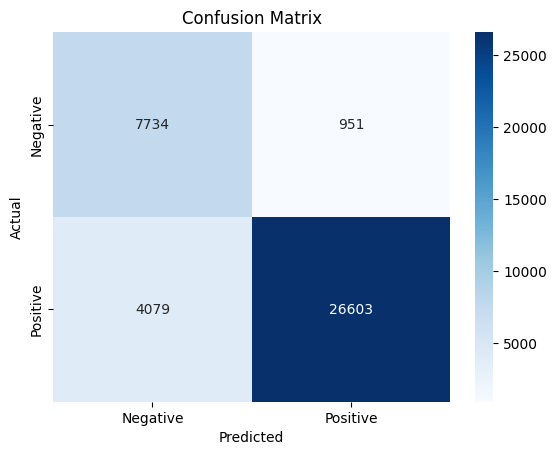

In [10]:
cm = confusion_matrix(true_labels, predictions)

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Negative", "Positive"],
    yticklabels=["Negative", "Positive"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [20]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def predict_sentiment(text, model, tokenizer, device):
    inputs = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=1).item()

    return {0: "Negative", 1: "Positive"}[predicted_class]


print(predict_sentiment("Ham is bad and my brother didn't like it", model, tokenizer, device))


Negative
